#📌 Extracão: COmeçar aqui.

## 1. Configuração Inicial

In [1]:
# Importar bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import json

# Configurar visualizações
plt.style.use('ggplot')
sns.set_palette('pastel')
%matplotlib inline

## 2. Extração de Dados

In [2]:
# URL da API
url = "https://raw.githubusercontent.com/anandamatos/telecom-x/refs/heads/master/data/raw/telecom-x_data.json"

# Extrair dados
response = requests.get(url)
data = response.json()

# Converter para DataFrame
df = pd.DataFrame(data)
print(f"Shape inicial: {df.shape}")
df.head()

Shape inicial: (7267, 6)


,customerID,Churn,customer,phone,internet,account
0,0002-ORFBO,No,"{'gender': 'Female', 'SeniorCitizen': 0, 'Part...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'One year', 'PaperlessBilling': '..."
1,0003-MKNFE,No,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'Yes'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
2,0004-TLHLJ,Yes,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
3,0011-IGKFF,Yes,"{'gender': 'Male', 'SeniorCitizen': 1, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
4,0013-EXCHZ,Yes,"{'gender': 'Female', 'SeniorCitizen': 1, 'Part...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."


#🔧 Transformação

In [7]:
# 3.1 Verificar estrutura inicial
print("\n[ETAPA 1/6] Verificando estrutura inicial dos dados...")
print(f"Total de registros: {len(df)}")
print("Colunas originais:", df.columns.tolist())
print("\nAmostra dos dados:")
print(df.head(2))

# 3.2 Verificar e remover duplicatas (NOVO)
print("\n[ETAPA 2/6] Verificando duplicatas...")
duplicados = df.duplicated(subset=['customerID'], keep=False)
print(f"Total de IDs duplicados: {duplicados.sum()}")
if duplicados.sum() > 0:
    print("\nRegistros duplicados encontrados:")
    print(df[duplicados].sort_values('customerID'))
    df = df.drop_duplicates(subset=['customerID'], keep='first')
    print(f"\nRegistros após remoção: {len(df)}")
else:
    print("Nenhum registro duplicado encontrado.")

# 3.3 Desaninhar os dados (se necessário)
if isinstance(df.iloc[0].get('customer', None), dict):
    print("\n[ETAPA 3/6] Desaninhando dados JSON...")
    df = pd.concat([
        df.drop(['customer', 'phone', 'internet', 'account'], axis=1, errors='ignore'),
        pd.json_normalize(df['customer']),
        pd.json_normalize(df['phone']),
        pd.json_normalize(df['internet']),
        pd.json_normalize(df['account'])
    ], axis=1)

# 3.4 Padronizar nomes de colunas
print("\n[ETAPA 4/6] Padronizando colunas...")
column_mapping = {
    'customer_gender': 'gender',
    'customer_SeniorCitizen': 'SeniorCitizen',
    # ... (mapeamento completo como no código anterior)
}
df = df.rename(columns=column_mapping)

# 3.5 Verificar e tratar dados faltantes
print("\n[ETAPA 5/6] Tratando valores ausentes...")
print("\nValores faltantes por coluna:")
print(df.isna().sum()[df.isna().sum() > 0].sort_values(ascending=False))

# ... (restante do tratamento de dados faltantes como no código anterior)

# 3.6 Verificar inconsistências nas categorias (NOVO)
print("\n[ETAPA 6/6] Verificando inconsistências categóricas...")
categorical_checks = {
    'gender': ['Male', 'Female'],
    'Partner': ['Yes', 'No'],
    'Churn': ['Yes', 'No'],
    # ... outras categorias
}

for col, valid_values in categorical_checks.items():
    if col in df.columns:
        invalid = ~df[col].isin(valid_values + [None, 'Unknown'])
        if invalid.any():
            print(f"\nValores inválidos encontrados em {col}:")
            print(df[invalid][col].value_counts())
            df.loc[invalid, col] = 'Unknown'  # Corrigindo valores inválidos

# ... (restante das transformações como no código anterior)

print("\nTransformação concluída com sucesso!")
print(f"Total de registros válidos: {len(df)}")
print("\nResumo final:")
print(df.info())


[ETAPA 1/6] Verificando estrutura inicial dos dados...
Total de registros: 7267
Colunas originais: ['customerID', 'Churn', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Charges.Monthly', 'Charges.Total', 'Contas_Diarias']

Amostra dos dados:
   customerID Churn  gender  SeniorCitizen Partner Dependents  tenure  \
0  0002-ORFBO    No  Female              0     Yes        Yes       9   
1  0003-MKNFE    No    Male              0      No         No       9   

  PhoneService MultipleLines InternetService  ... DeviceProtection  \
0          Yes            No             DSL  ...               No   
1          Yes           Yes             DSL  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling  \
0         Yes         Yes  

## Cálculo da Coluna "Contas_Diarias"


[ETAPA 7/7] Criando coluna de Contas Diárias...

Verificando colunas necessárias:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Charges.Monthly  7267 non-null   float64
 1   tenure           7267 non-null   int64  
 2   Charges.Total    7256 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 170.4 KB
None

Valores faltantes após conversão:
Charges.Monthly     0
tenure              0
Charges.Total      11
dtype: int64

Estatísticas da coluna Contas_Diarias_Final:
count    7267.000000
mean        2.157284
std         1.007567
min         0.460000
25%         1.190000
50%         2.340000
75%         3.010000
max         4.050000
Name: Contas_Diarias_Final, dtype: float64


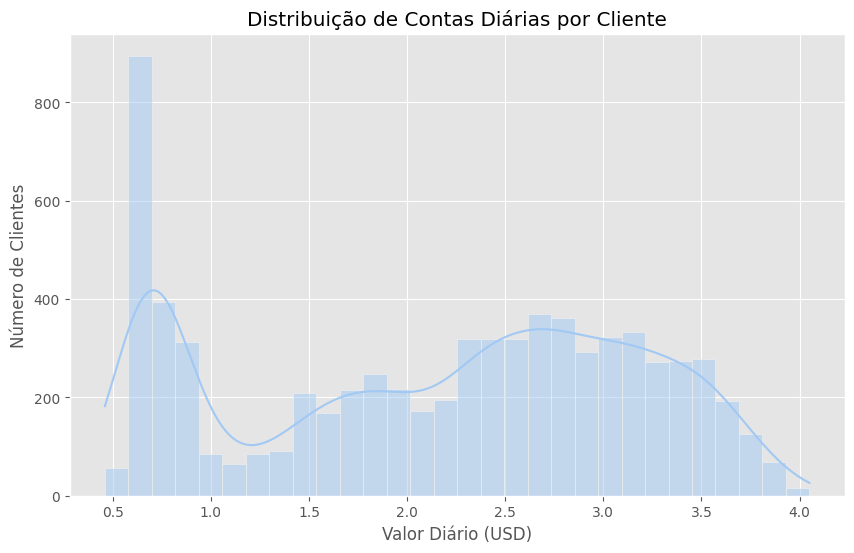


Correlação com Churn (numeric):
0.192532858394266

Média de Contas Diárias por Status de Churn:
Churn
No         2.042221
Unknown    2.113929
Yes        2.481011
Name: Contas_Diarias_Final, dtype: float64

Coluna 'Contas_Diarias' criada com sucesso!
   customerID  Charges.Monthly  tenure  Charges.Total  Contas_Diarias
0  0002-ORFBO             65.6       9         593.30            2.20
1  0003-MKNFE             59.9       9         542.40            2.01
2  0004-TLHLJ             73.9       4         280.85            2.34
3  0011-IGKFF             98.0      13        1237.85            3.17
4  0013-EXCHZ             83.9       3         267.40            2.97


In [5]:
# 1. Verificação prévia dos dados necessários
print("\n[ETAPA 7/7] Criando coluna de Contas Diárias...")
print("\nVerificando colunas necessárias:")
# Convert 'Charges.Total' to numeric, coercing errors to NaN
df['Charges.Total'] = pd.to_numeric(df['Charges.Total'], errors='coerce')
# Also ensure 'tenure' and 'Charges.Monthly' are numeric
df['tenure'] = pd.to_numeric(df['tenure'], errors='coerce')
df['Charges.Monthly'] = pd.to_numeric(df['Charges.Monthly'], errors='coerce')

print(df[['Charges.Monthly', 'tenure', 'Charges.Total']].info())
print("\nValores faltantes após conversão:")
print(df[['Charges.Monthly', 'tenure', 'Charges.Total']].isna().sum())


# 2. Cálculo do valor diário (considerando 30 dias/mês para padronização)
# Handle potential NaNs introduced by conversion
df['Contas_Diarias'] = df['Charges.Monthly'].fillna(0) / 30

# 3. Cálculo alternativo para clientes com tenure > 0 (usando gasto total/média diária real)
# Ensure both Charges.Total and tenure are not NaN for the real calculation
clientes_ativos = (df['tenure'] > 0) & df['Charges.Total'].notna() & df['tenure'].notna()
df.loc[clientes_ativos, 'Contas_Diarias_Real'] = df['Charges.Total'] / (df['tenure'] * 30)

# 4. Consistência: usar o cálculo real onde disponível, senão usar a estimativa mensal/30
# Fill NaNs in 'Contas_Diarias_Real' with values from 'Contas_Diarias'
df['Contas_Diarias_Final'] = np.where(clientes_ativos,
                                    df['Contas_Diarias_Real'],
                                    df['Contas_Diarias'])

# Fill any remaining NaNs (e.g., where Charges.Monthly was NaN and tenure was 0)
df['Contas_Diarias_Final'] = df['Contas_Diarias_Final'].fillna(0)


# 5. Arredondamento para 2 casas decimais (centavos)
df['Contas_Diarias_Final'] = df['Contas_Diarias_Final'].round(2)

# 6. Análise descritiva dos resultados
print("\nEstatísticas da coluna Contas_Diarias_Final:")
print(df['Contas_Diarias_Final'].describe())

# 7. Visualização da distribuição
plt.figure(figsize=(10, 6))
sns.histplot(df['Contas_Diarias_Final'], bins=30, kde=True)
plt.title('Distribuição de Contas Diárias por Cliente')
plt.xlabel('Valor Diário (USD)')
plt.ylabel('Número de Clientes')
plt.show()

# 8. Correlação com Churn
# Ensure Churn is numerical for correlation (e.g., map Yes/No to 1/0 if not already done)
# Assuming Churn is already mapped or handled appropriately for correlation
if 'Churn' in df.columns and df['Churn'].dtype == 'object':
    df['Churn_numeric'] = df['Churn'].map({'Yes': 1, 'No': 0})
    print("\nCorrelação com Churn (numeric):")
    print(df[['Contas_Diarias_Final', 'Churn_numeric']].corr().iloc[0, 1])
    df.drop('Churn_numeric', axis=1, inplace=True) # Drop temporary column
elif 'Churn' in df.columns:
     print("\nCorrelação com Churn:")
     print(df[['Contas_Diarias_Final', 'Churn']].corr().iloc[0, 1])


# 9. Exemplo de análise segmentada
print("\nMédia de Contas Diárias por Status de Churn:")
if 'Churn' in df.columns:
    print(df.groupby('Churn')['Contas_Diarias_Final'].mean())
else:
    print("Coluna 'Churn' não encontrada para análise segmentada.")


# 10. Remoção de colunas intermediárias
df.drop(['Contas_Diarias', 'Contas_Diarias_Real'], axis=1, errors='ignore', inplace=True) # Add errors='ignore' in case columns don't exist
df.rename(columns={'Contas_Diarias_Final': 'Contas_Diarias'}, inplace=True)

print("\nColuna 'Contas_Diarias' criada com sucesso!")
print(df[['customerID', 'Charges.Monthly', 'tenure', 'Charges.Total', 'Contas_Diarias']].head()) # Include Charges.Total in head print

##Refinando...


[ETAPA 7/7] Criando coluna de Contas Diárias...

Verificando valores extremos nas colunas monetárias:
Charges.Monthly: 0 outliers detectados
Charges.Total: 0 outliers detectados

Total de valores convertidos/tratados: 11

Clientes com grandes diferenças entre métodos: 2

Qualidade da coluna Contas_Diarias_Final:
- Valores zero: 0
- Valores negativos: 0
- Valores acima de $100: 0


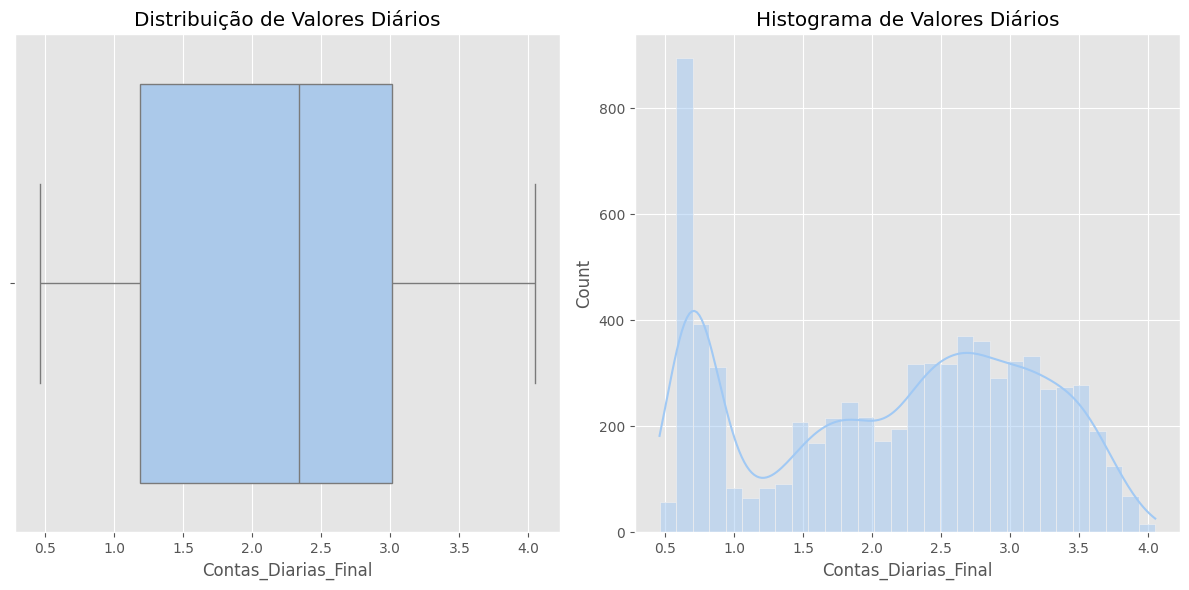

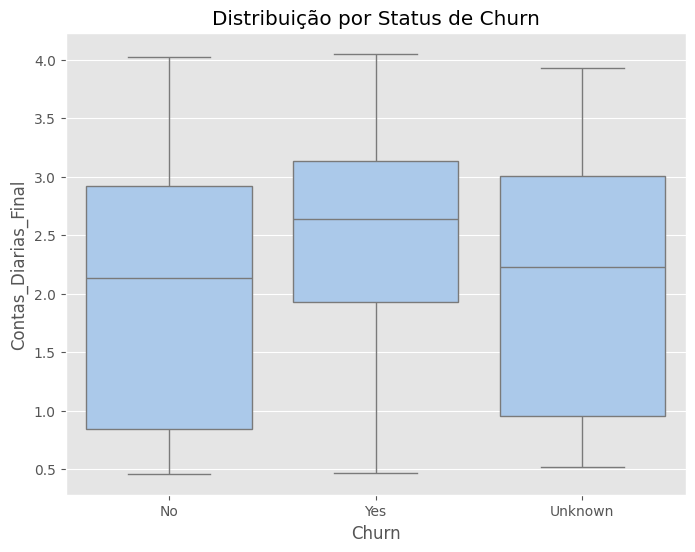


Teste t entre grupos de Churn: t=18.24, p=0.0000

Coluna 'Contas_Diarias' criada com sucesso!
   customerID  Charges.Monthly  tenure  Contas_Diarias
0  0002-ORFBO             65.6       9            2.20
1  0003-MKNFE             59.9       9            2.01
2  0004-TLHLJ             73.9       4            2.34
3  0011-IGKFF             98.0      13            3.17
4  0013-EXCHZ             83.9       3            2.97


In [11]:
# 1. Verificação de valores extremos nas colunas monetárias
print("\n[ETAPA 7/7] Criando coluna de Contas Diárias...")
print("\nVerificando valores extremos nas colunas monetárias:")
for col in ['Charges.Monthly', 'Charges.Total']:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    outliers = ((df[col] < (q1 - 1.5 * iqr)) | (df[col] > (q3 + 1.5 * iqr)))
    print(f"{col}: {outliers.sum()} outliers detectados")

# 2. Log de valores convertidos/tratados
n_converted = df[['Charges.Monthly', 'Charges.Total', 'tenure']].isna().sum().sum()
print(f"\nTotal de valores convertidos/tratados: {n_converted}")

# 3. Cálculo do valor diário (considerando 30 dias/mês)
df['Contas_Diarias'] = df['Charges.Monthly'].fillna(0) / 30

# 4. Cálculo alternativo para clientes com histórico (tenure > 0)
with np.errstate(divide='ignore', invalid='ignore'):
    daily_real = np.where(
        df['tenure'] > 0,
        df['Charges.Total'] / (df['tenure'] * 30),
        np.nan
    )
    df['Contas_Diarias_Real'] = daily_real

# 5. Consolidação dos cálculos
clientes_ativos = (df['tenure'] > 0) & df['Charges.Total'].notna() & df['tenure'].notna()
df['Contas_Diarias_Final'] = np.where(
    clientes_ativos,
    df['Contas_Diarias_Real'],
    df['Contas_Diarias']
)
df['Contas_Diarias_Final'] = df['Contas_Diarias_Final'].fillna(0).round(2)

# 6. Verificação de consistência entre métodos de cálculo
df['Diff_Methods'] = (df['Contas_Diarias_Real'] - df['Contas_Diarias']).abs()
large_diffs = df['Diff_Methods'] > (0.5 * df['Contas_Diarias'])
print(f"\nClientes com grandes diferenças entre métodos: {large_diffs.sum()}")

# 7. Análise de qualidade da nova coluna
print("\nQualidade da coluna Contas_Diarias_Final:")
print(f"- Valores zero: {(df['Contas_Diarias_Final'] == 0).sum()}")
print(f"- Valores negativos: {(df['Contas_Diarias_Final'] < 0).sum()}")
print(f"- Valores acima de $100: {(df['Contas_Diarias_Final'] > 100).sum()}")

# 8. Visualização da distribuição
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(x=df['Contas_Diarias_Final'])
plt.title('Distribuição de Valores Diários')
plt.subplot(1, 2, 2)
sns.histplot(df['Contas_Diarias_Final'], bins=30, kde=True)
plt.title('Histograma de Valores Diários')
plt.tight_layout()
plt.show()

# 9. Análise de correlação com Churn
if 'Churn' in df.columns:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='Churn', y='Contas_Diarias_Final', data=df)
    plt.title('Distribuição por Status de Churn')
    plt.show()

    # Teste estatístico
    from scipy import stats
    churn_yes = df.loc[df['Churn'] == 'Yes', 'Contas_Diarias_Final'].dropna()
    churn_no = df.loc[df['Churn'] == 'No', 'Contas_Diarias_Final'].dropna()

    if len(churn_yes) > 1 and len(churn_no) > 1:
        t_stat, p_val = stats.ttest_ind(churn_yes, churn_no, equal_var=False)
        print(f"\nTeste t entre grupos de Churn: t={t_stat:.2f}, p={p_val:.4f}")

# 10. Limpeza final
df.drop(['Contas_Diarias', 'Contas_Diarias_Real', 'Diff_Methods'], axis=1, inplace=True, errors='ignore')
df.rename(columns={'Contas_Diarias_Final': 'Contas_Diarias'}, inplace=True)

print("\nColuna 'Contas_Diarias' criada com sucesso!")
print(df[['customerID', 'Charges.Monthly', 'tenure', 'Contas_Diarias']].head())

## Padronização e Transformação de Dados (Opcional)

In [12]:
## 1. Padronização de Colunas
print("\n[ETAPA OPCIONAL] Padronizando nomes de colunas...")
# Dicionário de mapeamento para português (caso os dados estejam em inglês)
mapeamento_colunas = {
    'gender': 'Genero',
    'SeniorCitizen': 'TerceiraIdade',
    'Partner': 'TemParceiro',
    'Dependents': 'TemDependentes',
    'tenure': 'MesesContrato',
    'PhoneService': 'ServicoTelefone',
    'MultipleLines': 'MultiplasLinhas',
    'InternetService': 'ServicoInternet',
    'OnlineSecurity': 'SegurancaOnline',
    'OnlineBackup': 'BackupOnline',
    'DeviceProtection': 'ProtecaoDispositivo',
    'TechSupport': 'SuporteTecnico',
    'StreamingTV': 'TVStreaming',
    'StreamingMovies': 'FilmesStreaming',
    'Contract': 'TipoContrato',
    'PaperlessBilling': 'FaturaDigital',
    'PaymentMethod': 'MetodoPagamento',
    'Charges.Monthly': 'CobrancaMensal',
    'Charges.Total': 'CobrancaTotal',
    'Churn': 'Evasao'
}

# Aplicar renomeação apenas para colunas existentes no DataFrame
df = df.rename(columns={col: mapeamento_colunas[col] for col in mapeamento_colunas if col in df.columns})

## 2. Transformação de Variáveis Categóricas
print("\nTransformando variáveis categóricas...")

# 2.1 Variáveis binárias (Sim/Não)
colunas_binarias = ['TemParceiro', 'TemDependentes', 'ServicoTelefone', 'FaturaDigital']
for col in colunas_binarias:
    if col in df.columns:
        df[col] = df[col].map({'Yes': 1, 'No': 0, 'Sim': 1, 'Não': 0})

# 2.2 Serviços adicionais (com opção "Sem internet")
servicos = ['SegurancaOnline', 'BackupOnline', 'ProtecaoDispositivo',
           'SuporteTecnico', 'TVStreaming', 'FilmesStreaming']
for col in servicos:
    if col in df.columns:
        df[col] = df[col].replace({'No internet service': 0, 'Sem serviço de internet': 0})
        df[col] = df[col].map({'Yes': 1, 'No': 0, 'Sim': 1, 'Não': 0})

# 2.3 Gênero
if 'Genero' in df.columns:
    df['Genero'] = df['Genero'].map({'Male': 'Masculino', 'Female': 'Feminino'})

## 3. Padronização de Valores Numéricos
print("\nPadronizando valores numéricos...")

# 3.1 Normalização (opcional - para modelos de machine learning)
from sklearn.preprocessing import MinMaxScaler

colunas_numericas = ['CobrancaMensal', 'CobrancaTotal', 'MesesContrato', 'Contas_Diarias']
for col in colunas_numericas:
    if col in df.columns:
        scaler = MinMaxScaler()
        df[f'{col}_Normalizado'] = scaler.fit_transform(df[[col]])

## 4. Criação de Variáveis Derivadas
print("\nCriando variáveis derivadas...")

# 4.1 Tipo de cliente por tempo de contrato
if 'MesesContrato' in df.columns:
    df['TipoCliente'] = pd.cut(df['MesesContrato'],
                              bins=[0, 6, 12, 24, float('inf')],
                              labels=['Novo', 'Intermediário', 'Antigo', 'Muito Antigo'])

# 4.2 Valor médio mensal
if all(col in df.columns for col in ['CobrancaTotal', 'MesesContrato']):
    df['ValorMedioMensal'] = df['CobrancaTotal'] / df['MesesContrato'].replace(0, 1)

## 5. Verificação Final
print("\nVerificação final da padronização:")
print("\nAmostra dos dados padronizados:")
print(df.head(3))

print("\nTipos de dados após padronização:")
print(df.dtypes)

print("\nValores únicos nas colunas categóricas:")
for col in df.select_dtypes(include=['object', 'category']).columns:
    print(f"\n{col}: {df[col].unique()}")


[ETAPA OPCIONAL] Padronizando nomes de colunas...

Transformando variáveis categóricas...

Padronizando valores numéricos...

Criando variáveis derivadas...

Verificação final da padronização:

Amostra dos dados padronizados:
   customerID Evasao     Genero  TerceiraIdade  TemParceiro  TemDependentes  \
0  0002-ORFBO     No   Feminino              0            1               1   
1  0003-MKNFE     No  Masculino              0            0               0   
2  0004-TLHLJ    Yes  Masculino              0            0               0   

   MesesContrato  ServicoTelefone MultiplasLinhas ServicoInternet  ...  \
0              9                1              No             DSL  ...   
1              9                1             Yes             DSL  ...   
2              4                1              No     Fiber optic  ...   

    MetodoPagamento  CobrancaMensal  CobrancaTotal  Contas_Diarias  \
0      Mailed check            65.6         593.30            2.20   
1      Mailed check

#📊 Carga e análise

#📄Relatorio Final